# Transportation & Route Planning (KPI-driven, OR-supported)
Teaching flow: Theory → Math → Code

Dataset file: `transport_route_planning_or.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# OR solver (linear / integer programming)
# In Google Colab, PuLP may not be preinstalled.
# If needed, run: !pip -q install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpStatus, value


In [4]:
# Load dataset
# Colab tip: upload the CSV into the session files, or mount Google Drive.

path = "/Users/gollapsi/Documents/17_Hof_Lecture_Code_Pingo/Supply_Chain_Analytics/data/transport_route_planning_or.csv"
df_raw = pd.read_csv(path)

df_raw.head()


,order_id,ship_date,origin_node,destination_node,order_qty_units,distance_km,planned_travel_time_hr,actual_travel_time_hr,dispatch_policy,vehicle_id,route_id,vehicle_capacity_units,fixed_trip_cost_eur,variable_cost_per_km_eur,planned_departure_hour,delivery_window_hr,on_time_flag
0,O00001,2026-01-05,DC_Erlangen,CUST_14,244,161.3,3.15,3.95,4hr_Consolidate,TRUCK_4,20260105_TRUCK_4,1200,95,0.80,9,4,1
1,O00002,2026-01-05,DC_Erlangen,CUST_09,165,106.5,3.33,3.63,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.87,8,8,1
2,O00003,2026-01-05,DC_Erlangen,CUST_10,577,123.5,2.07,2.37,Immediate,TRUCK_3,20260105_TRUCK_3,1200,95,0.92,7,8,0
3,O00004,2026-01-05,DC_Erlangen,CUST_01,55,39.0,0.85,1.65,Immediate,TRUCK_1,20260105_TRUCK_1,1200,95,0.93,8,5,1
4,O00005,2026-01-05,DC_Erlangen,CUST_16,90,172.4,4.71,4.71,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.86,7,8,1


In [5]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    """Return missing value counts and % by column."""
    out = pd.DataFrame({
        "missing_n": df.isna().sum(),
        "missing_pct": (df.isna().mean() * 100).round(2)
    }).sort_values(["missing_n", "missing_pct"], ascending=False)
    return out

def duplicate_report(df: pd.DataFrame, subset=None) -> int:
    """Count duplicates. Use subset keys for business-relevant duplicate checks."""
    return int(df.duplicated(subset=subset).sum())

def step_check(name: str, condition: bool) -> None:
    status = "PASS" if condition else "FAIL"
    print(f"[{status}] {name}")

def route_level_table(df: pd.DataFrame, route_col: str = "route_id") -> pd.DataFrame:
    """Aggregate order lines into route-level metrics."""
    g = df.groupby(route_col, as_index=False).agg(
        ship_date=("ship_date", "first"),
        vehicle_id=("vehicle_id", "first"),
        vehicle_capacity_units=("vehicle_capacity_units", "first"),
        fixed_trip_cost_eur=("fixed_trip_cost_eur", "first"),
        total_order_qty=("order_qty_units", "sum"),
        total_distance_km=("distance_km", "sum"),
        avg_var_cost_per_km=("variable_cost_per_km_eur", "mean"),
        on_time_rate=("on_time_flag", "mean"),
    )
    g["utilization"] = g["total_order_qty"] / g["vehicle_capacity_units"]
    g["variable_cost_eur"] = g["total_distance_km"] * g["avg_var_cost_per_km"]
    g["route_total_cost_eur"] = g["fixed_trip_cost_eur"] + g["variable_cost_eur"]
    return g

def kpi_summary(df: pd.DataFrame, route_col: str = "route_id") -> dict:
    """Compute KPI summary consistent with slides."""
    routes = route_level_table(df, route_col=route_col)
    total_cost = routes["route_total_cost_eur"].sum()
    cost_per_order = total_cost / len(df)
    return {
        "orders": int(len(df)),
        "routes": int(routes.shape[0]),
        "total_cost_eur": float(total_cost),
        "cost_per_order_eur": float(cost_per_order),
        "avg_utilization": float(routes["utilization"].mean()),
        "on_time_rate": float(df["on_time_flag"].mean()),
        "avg_distance_km": float(df["distance_km"].mean()),
        "pct_over_capacity_routes": float((routes["utilization"] > 1.0).mean()),
    }


In [6]:
# STEP 1A (SEE): Identify data issues that distort transportation KPIs

print("Missing values:")
display(missing_report(df_raw).head(10))

print("\nDuplicate order lines (business key = order_id + ship_date):")
dups = duplicate_report(df_raw, subset=["order_id", "ship_date"])
print("Duplicate rows:", dups)

# Range checks (typical transportation sanity)
step_check("No negative distances", (df_raw["distance_km"] >= 0).all())
step_check("Planned travel time not missing", df_raw["planned_travel_time_hr"].notna().all())


Missing values:


,missing_n,missing_pct
planned_travel_time_hr,3,1.65
order_id,0,0.00
ship_date,0,0.00
origin_node,0,0.00
destination_node,0,0.00
order_qty_units,0,0.00
distance_km,0,0.00
actual_travel_time_hr,0,0.00
dispatch_policy,0,0.00
vehicle_id,0,0.00



Duplicate order lines (business key = order_id + ship_date):
Duplicate rows: 2
[FAIL] No negative distances
[FAIL] Planned travel time not missing


In [7]:
# STEP 1B (TREAT): Fix the issues

df_treat = df_raw.copy()

# 1) Drop duplicates on business key
df_treat = df_treat.drop_duplicates(subset=["order_id", "ship_date"], keep="first")

# 2) Fix negative distances
df_treat.loc[df_treat["distance_km"] < 0, "distance_km"] = df_treat.loc[df_treat["distance_km"] < 0, "distance_km"].abs()

# 3) Impute missing planned travel time (55 km/h assumption)
missing = df_treat["planned_travel_time_hr"].isna()
df_treat.loc[missing, "planned_travel_time_hr"] = (df_treat.loc[missing, "distance_km"] / 55).round(2)

# 4) Fix implausible planned travel times (speed > 120 km/h)
speed = df_treat["distance_km"] / df_treat["planned_travel_time_hr"]
bad = speed > 120
df_treat.loc[bad, "planned_travel_time_hr"] = (df_treat.loc[bad, "distance_km"] / 70).round(2)

# 5) Recompute on_time flag consistently
df_treat["on_time_flag"] = (df_treat["actual_travel_time_hr"] <= df_treat["delivery_window_hr"]).astype(int)

df_treat.head()


,order_id,ship_date,origin_node,destination_node,order_qty_units,distance_km,planned_travel_time_hr,actual_travel_time_hr,dispatch_policy,vehicle_id,route_id,vehicle_capacity_units,fixed_trip_cost_eur,variable_cost_per_km_eur,planned_departure_hour,delivery_window_hr,on_time_flag
0,O00001,2026-01-05,DC_Erlangen,CUST_14,244,161.3,3.15,3.95,4hr_Consolidate,TRUCK_4,20260105_TRUCK_4,1200,95,0.80,9,4,1
1,O00002,2026-01-05,DC_Erlangen,CUST_09,165,106.5,3.33,3.63,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.87,8,8,1
2,O00003,2026-01-05,DC_Erlangen,CUST_10,577,123.5,2.07,2.37,Immediate,TRUCK_3,20260105_TRUCK_3,1200,95,0.92,7,8,1
3,O00004,2026-01-05,DC_Erlangen,CUST_01,55,39.0,0.85,1.65,Immediate,TRUCK_1,20260105_TRUCK_1,1200,95,0.93,8,5,1
4,O00005,2026-01-05,DC_Erlangen,CUST_16,90,172.4,4.71,4.71,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.86,7,8,1


In [8]:
# STEP 1C (VERIFY): Confirm the dataset is now KPI-safe

step_check("No negative distances", (df_treat["distance_km"] >= 0).all())
step_check("No missing planned travel time", df_treat["planned_travel_time_hr"].notna().all())
step_check("Duplicate rows removed", duplicate_report(df_treat, subset=["order_id","ship_date"]) == 0)

print("\nBaseline KPI summary (post-cleaning):")
baseline_kpis = kpi_summary(df_treat, route_col="route_id")
baseline_kpis


[PASS] No negative distances
[PASS] No missing planned travel time
[PASS] Duplicate rows removed

Baseline KPI summary (post-cleaning):


{'orders': 180,
 'routes': 58,
 'total_cost_eur': 24900.214454761903,
 'cost_per_order_eur': 138.33452474867724,
 'avg_utilization': 0.7387643678160919,
 'on_time_rate': 0.9444444444444444,
 'avg_distance_km': 117.90777777777778,
 'pct_over_capacity_routes': 0.20689655172413793}


Key descriptive views:
Avg utilization: 0.74
Routes over capacity (utilization > 1.0): 12
On-time rate (order-level): 0.944


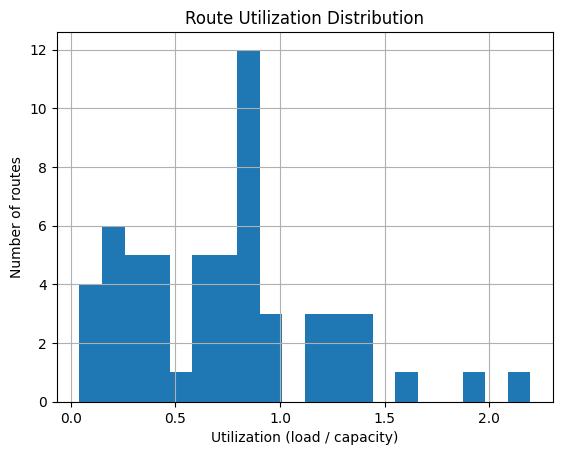

In [9]:
# STEP 2 (DESCRIPTIVE): What is happening?

routes = route_level_table(df_treat, route_col="route_id")
routes[["ship_date","vehicle_id","total_order_qty","vehicle_capacity_units","utilization","route_total_cost_eur","on_time_rate"]].head()

print("\nKey descriptive views:")
print("Avg utilization:", round(routes["utilization"].mean(), 2))
print("Routes over capacity (utilization > 1.0):", int((routes["utilization"] > 1.0).sum()))
print("On-time rate (order-level):", round(df_treat["on_time_flag"].mean(), 3))

plt.figure()
routes["utilization"].hist(bins=20)
plt.title("Route Utilization Distribution")
plt.xlabel("Utilization (load / capacity)")
plt.ylabel("Number of routes")
plt.show()


In [10]:
# STEP 3 (DIAGNOSTIC): Why are KPIs behaving this way?

print("KPI summary by dispatch_policy:")
policy_kpis = {}
for p, g in df_treat.groupby("dispatch_policy"):
    policy_kpis[p] = kpi_summary(g, route_col="route_id")
policy_kpis

routes_sorted = routes.sort_values("route_total_cost_eur", ascending=False).head(10)
print("\nTop 10 highest-cost routes:")
display(routes_sorted[["ship_date","vehicle_id","utilization","total_distance_km","route_total_cost_eur","on_time_rate"]])

over = routes[routes["utilization"] > 1.0]
pct_routes_over = (routes["utilization"] > 1.0).mean()
orders_on_over = df_treat[df_treat["route_id"].isin(over["route_id"])]
pct_orders_on_over = len(orders_on_over) / len(df_treat)

print("\nCapacity stress indicators:")
print("Share of routes overloaded:", round(pct_routes_over, 3))
print("Share of orders on overloaded routes:", round(pct_orders_on_over, 3))


KPI summary by dispatch_policy:

Top 10 highest-cost routes:


,ship_date,vehicle_id,utilization,total_distance_km,route_total_cost_eur,on_time_rate
35,2026-01-12,TRUCK_2,1.950833,976.7,951.357286,1.000000
43,2026-01-13,TRUCK_5,0.980000,839.7,855.653600,1.000000
14,2026-01-07,TRUCK_5,2.196667,841.2,852.230286,0.857143
23,2026-01-09,TRUCK_5,1.375000,846.8,836.836667,1.000000
55,2026-01-16,TRUCK_2,0.940833,688.4,726.118000,1.000000
41,2026-01-13,TRUCK_3,1.358333,687.8,722.142000,1.000000
9,2026-01-06,TRUCK_5,0.881667,643.4,691.753500,1.000000
17,2026-01-08,TRUCK_4,1.292500,650.9,677.584800,0.800000
56,2026-01-16,TRUCK_3,1.202500,614.1,651.943250,0.750000
15,2026-01-08,TRUCK_1,1.305833,604.1,640.601167,1.000000



Capacity stress indicators:
Share of routes overloaded: 0.207
Share of orders on overloaded routes: 0.35


In [11]:
# STEP 4 (PREDICTIVE - scenario math, no ML): Capacity stress test

df_scn = df_treat.copy()
df_scn["order_qty_units"] = (df_scn["order_qty_units"] * 1.10).round().astype(int)

routes_base = route_level_table(df_treat, route_col="route_id")
routes_scn = route_level_table(df_scn, route_col="route_id")

out = pd.DataFrame({
    "baseline_avg_util": [routes_base["utilization"].mean()],
    "scenario_avg_util": [routes_scn["utilization"].mean()],
    "baseline_pct_over_cap_routes": [(routes_base["utilization"] > 1.0).mean()],
    "scenario_pct_over_cap_routes": [(routes_scn["utilization"] > 1.0).mean()],
})
out


,baseline_avg_util,scenario_avg_util,baseline_pct_over_cap_routes,scenario_pct_over_cap_routes
0,0.738764,0.812629,0.206897,0.258621


In [14]:
# STEP 5 (PRESCRIPTIVE): OR-assisted assignment to improve capacity & cost

def solve_day(df_day: pd.DataFrame, truck_ids, capacity: int, fixed_cost: float = 110.0):
    orders = df_day.index.tolist()
    trucks = list(truck_ids)

    model = LpProblem("AssignDay", LpMinimize)
    x = LpVariable.dicts("x", (orders, trucks), 0, 1, LpBinary)
    y = LpVariable.dicts("y", trucks, 0, 1, LpBinary)

    # Variable cost per order-line (teaching simplification)
    var_cost = {i: float(df_day.loc[i,"distance_km"] * df_day.loc[i,"variable_cost_per_km_eur"]) for i in orders}

    # Objective
    model += fixed_cost * lpSum(y[v] for v in trucks) + lpSum(var_cost[i] * x[i][v] for i in orders for v in trucks)

    # Assign exactly once
    for i in orders:
        model += lpSum(x[i][v] for v in trucks) == 1

    # Link y
    for v in trucks:
        for i in orders:
            model += x[i][v] <= y[v]

    # Capacity
    for v in trucks:
        model += lpSum(float(df_day.loc[i,"order_qty_units"]) * x[i][v] for i in orders) <= capacity

    status = model.solve()
    if LpStatus[status] != "Optimal":
        return None

    assign = {}
    for i in orders:
        for v in trucks:
            if value(x[i][v]) > 0.5:
                assign[i] = v
                break
    return assign

# Apply OR day-by-day
df_or = df_treat.copy()
df_or["or_vehicle_id"] = None

for day, df_day in df_or.groupby("ship_date"):
    assign = solve_day(
        df_day,
        truck_ids=["TRUCK_1","TRUCK_2","TRUCK_3","TRUCK_4","TRUCK_5"],
        capacity=1200,
        fixed_cost=110
    )
    if assign is None:
        raise RuntimeError(f"Day {day} infeasible (check daily demand vs fleet capacity).")

    for idx, v in assign.items():
        df_or.at[idx, "or_vehicle_id"] = v

# Robust route_id creation (works whether ship_date is string or datetime)
ship_date_dt = pd.to_datetime(df_or["ship_date"], errors="coerce")
df_or["or_route_id"] = ship_date_dt.dt.strftime("%Y%m%d") + "_" + df_or["or_vehicle_id"].astype(str)

# KPI comparison (avoid duplicate route_id columns)
baseline = kpi_summary(df_treat, route_col="route_id")

df_or_eval = df_or.copy()
df_or_eval["route_id"] = df_or_eval["or_route_id"]   # overwrite route_id explicitly (single column)
after_or = kpi_summary(df_or_eval, route_col="route_id")

comparison = pd.DataFrame([baseline, after_or], index=["Baseline", "After_OR"])
comparison[["orders","routes","total_cost_eur","cost_per_order_eur","avg_utilization","on_time_rate","pct_over_capacity_routes"]]



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/envs/argos_env/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/c0d686619f9942929ba0c9a08dc57f54-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/c0d686619f9942929ba0c9a08dc57f54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 100 COLUMNS
At line 641 RHS
At line 737 BOUNDS
At line 818 ENDATA
Problem MODEL has 95 rows, 80 columns and 300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1327.33 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0004I processed model has 95 rows, 80 columns (80 integer (80 of which binary)) and 305 elements
Cutoff increment increased from 1e-05 to 0.000999
Cbc0038I Initial

,orders,routes,total_cost_eur,cost_per_order_eur,avg_utilization,on_time_rate,pct_over_capacity_routes
Baseline,180,58,24900.214455,138.334525,0.738764,0.944444,0.206897
After_OR,180,50,24098.865152,133.882584,0.856967,0.944444,0.000000


In [32]:
day_focus

'2026-01-05'

In [37]:
df_or.groupby("ship_date")["order_id"].count()

ship_date
2026-01-05    15
2026-01-06    15
2026-01-07    15
2026-01-08    15
2026-01-09    15
2026-01-10    15
2026-01-11    15
2026-01-12    15
2026-01-13    15
2026-01-14    15
2026-01-15    15
2026-01-16    15
Name: order_id, dtype: int64

In [41]:
# Choose a day with most orders (best for demonstration)
day_focus = (df_or.groupby("ship_date")["order_id"].count()
                   .sort_values(ascending=False)
                   .index[-5])

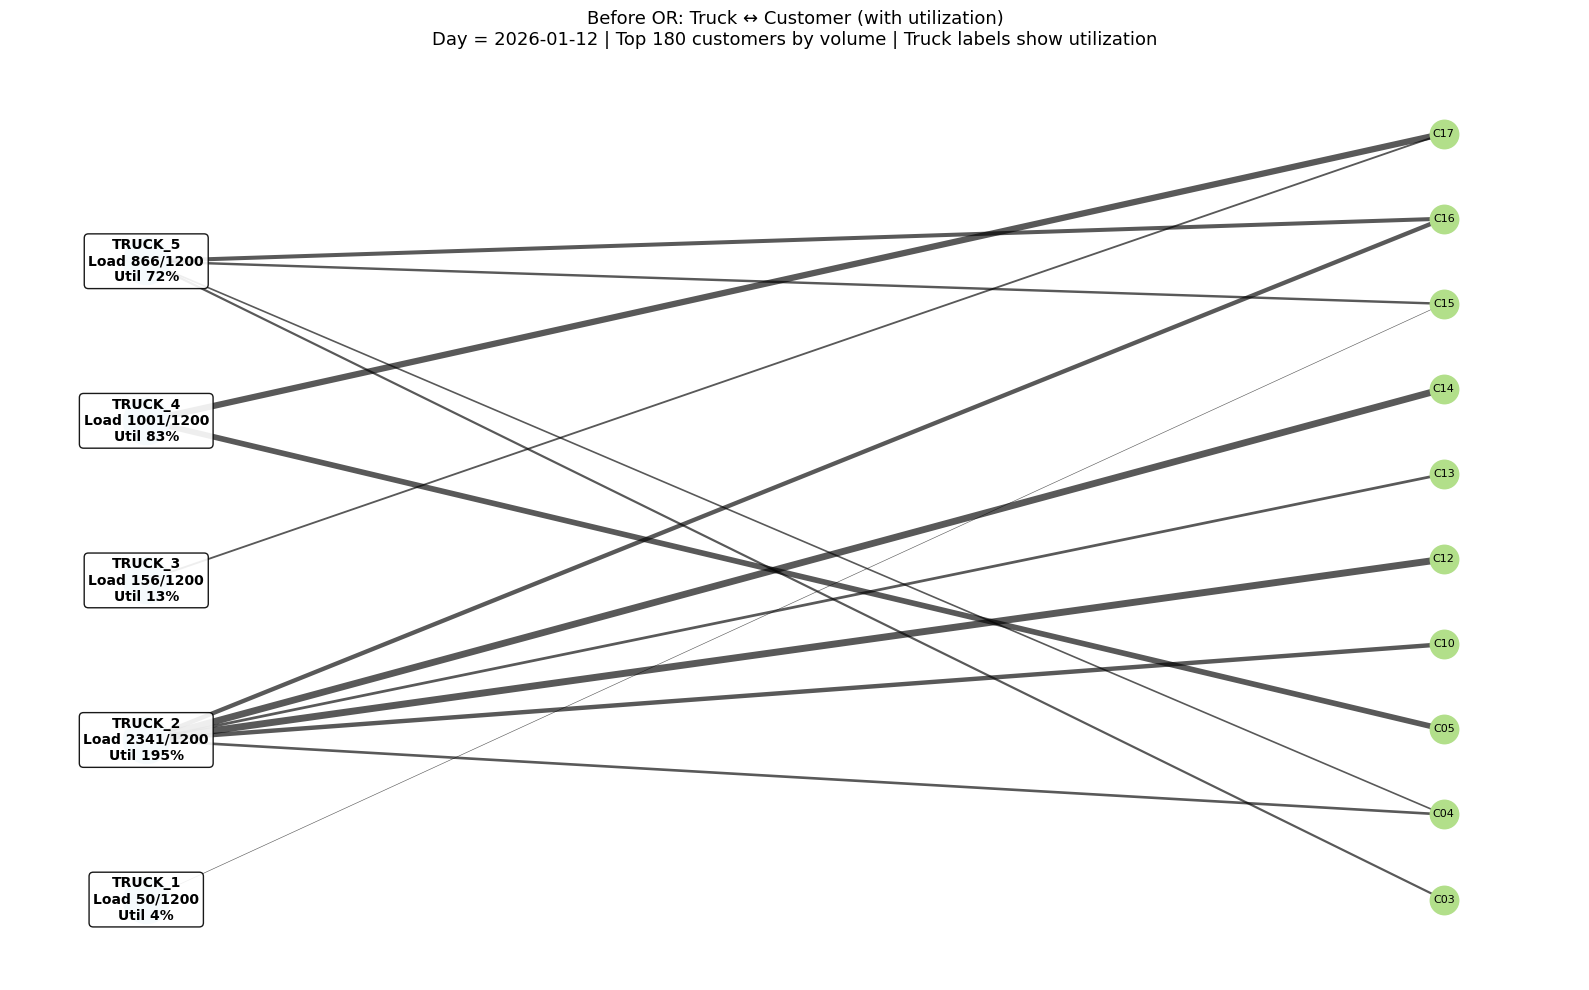

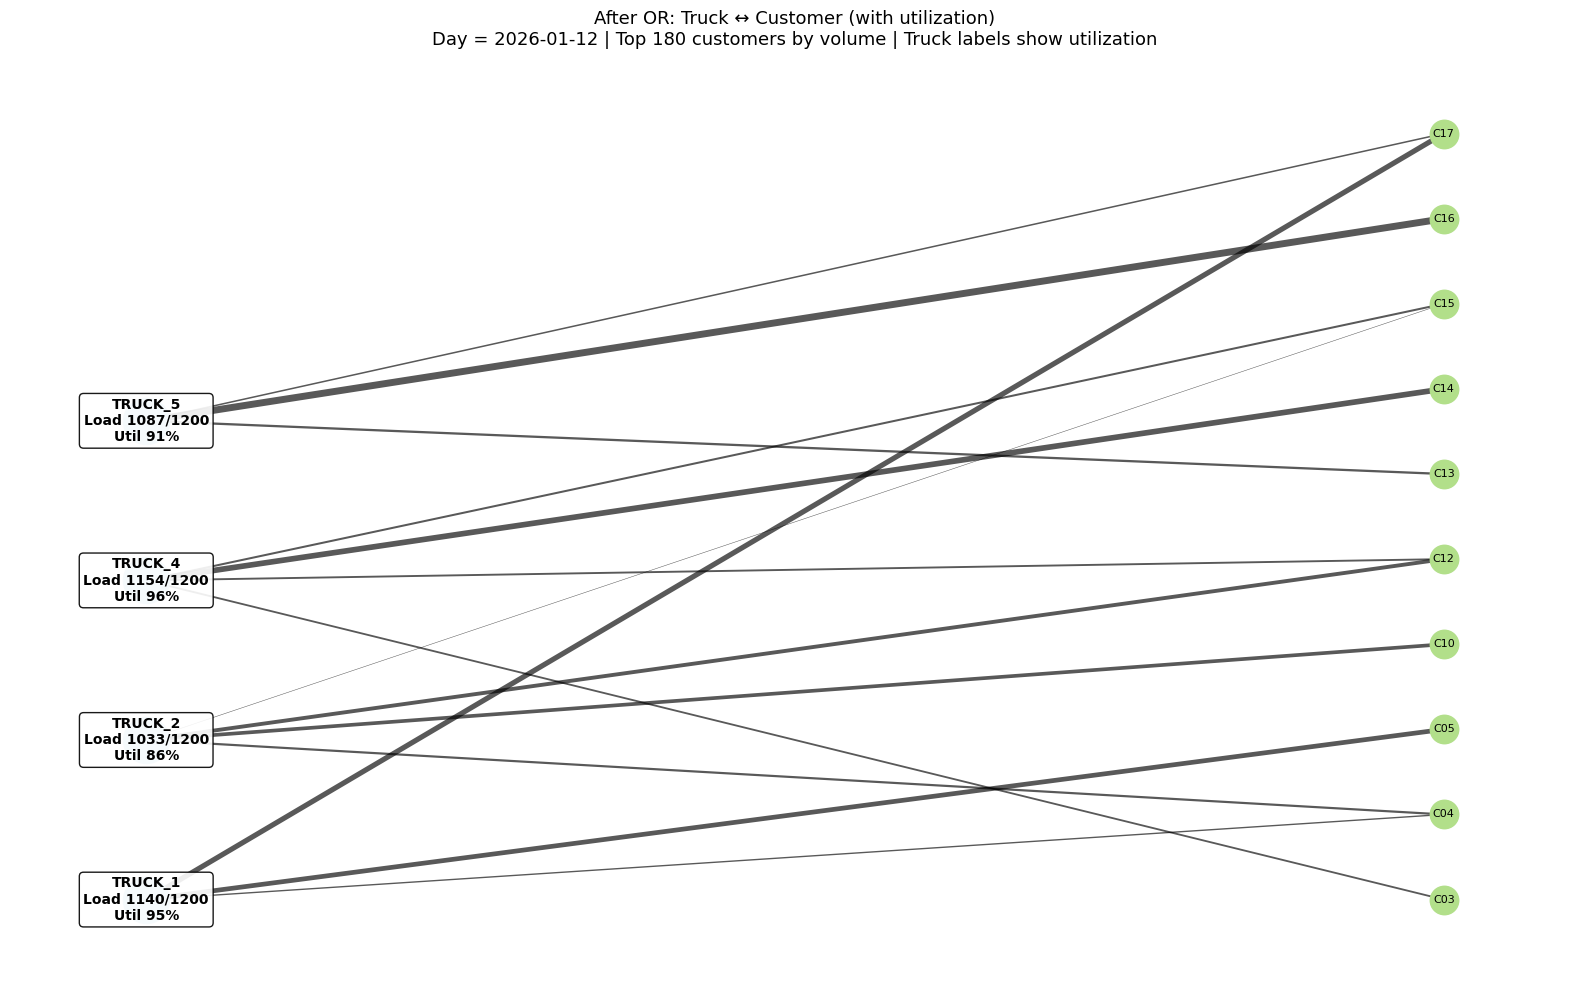

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def plot_bipartite_day_with_util(
    df,
    day,
    vehicle_col,
    title,
    top_n_customers=180,
    capacity_col="vehicle_capacity_units"
):
    d = df[df["ship_date"] == day].copy()
    if d.empty:
        raise ValueError(f"No rows found for day={day}")

    # Top customers by volume
    cust_rank = (
        d.groupby("destination_node")["order_qty_units"]
         .sum()
         .sort_values(ascending=False)
    )
    top_custs = cust_rank.head(top_n_customers).index.tolist()
    d = d[d["destination_node"].isin(top_custs)].copy()

    # Truck day load / utilization
    truck_day = (
        d.groupby(vehicle_col, as_index=False)
         .agg(load=("order_qty_units", "sum"),
              cap=(capacity_col, "max"))
    )
    truck_day["util"] = truck_day["load"] / truck_day["cap"]

    trucks = sorted(truck_day[vehicle_col].dropna().unique().tolist())
    custs  = sorted(d["destination_node"].dropna().unique().tolist())

    # Build graph
    G = nx.Graph()
    G.add_nodes_from(trucks, bipartite=0)
    G.add_nodes_from(custs,  bipartite=1)

    agg = (
        d.groupby([vehicle_col, "destination_node"], as_index=False)
         .agg(qty=("order_qty_units", "sum"))
    )

    for _, r in agg.iterrows():
        G.add_edge(r[vehicle_col], r["destination_node"], weight=float(r["qty"]))

    # Layout with stronger horizontal separation and vertical spacing
    pos = {}
    for i, t in enumerate(trucks):
        pos[t] = (0, i * 1.5)        # vertical stretch for trucks
    for j, c in enumerate(custs):
        pos[c] = (4, j * 0.8)        # move customers further right

    # Edge widths
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    w_scaled = [(w / max(weights) * 5) if weights else 1 for w in weights]

    # Truck labels with utilization (key teaching element)
    truck_label_map = {
        r[vehicle_col]: f"{r[vehicle_col]}\nLoad {int(r['load'])}/{int(r['cap'])}\nUtil {r['util']:.0%}"
        for _, r in truck_day.iterrows()
    }

    # Abbreviated customer labels (legibility)
    cust_label_map = {c: c.replace("CUST_", "C") for c in custs}

    plt.figure(figsize=(16, 10))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=trucks,
        node_size=1100,
        node_color="#A6CEE3"
    )
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=custs,
        node_size=420,
        node_color="#B2DF8A"
    )

    nx.draw_networkx_edges(
        G, pos,
        width=w_scaled,
        alpha=0.65
    )

    # Truck labels with background box
    nx.draw_networkx_labels(
        G, pos,
        labels=truck_label_map,
        font_size=10,
        font_weight="bold",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9)
    )

    # Customer labels (smaller, no box)
    nx.draw_networkx_labels(
        G, pos,
        labels=cust_label_map,
        font_size=8
    )

    plt.title(
        f"{title}\nDay = {day} | Top {top_n_customers} customers by volume | Truck labels show utilization",
        fontsize=13
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# usage
plot_bipartite_day_with_util(df_treat, day_focus, "vehicle_id", "Before OR: Truck ↔ Customer (with utilization)", top_n_customers=180)
plot_bipartite_day_with_util(df_or,    day_focus, "or_vehicle_id", "After OR: Truck ↔ Customer (with utilization)", top_n_customers=180)


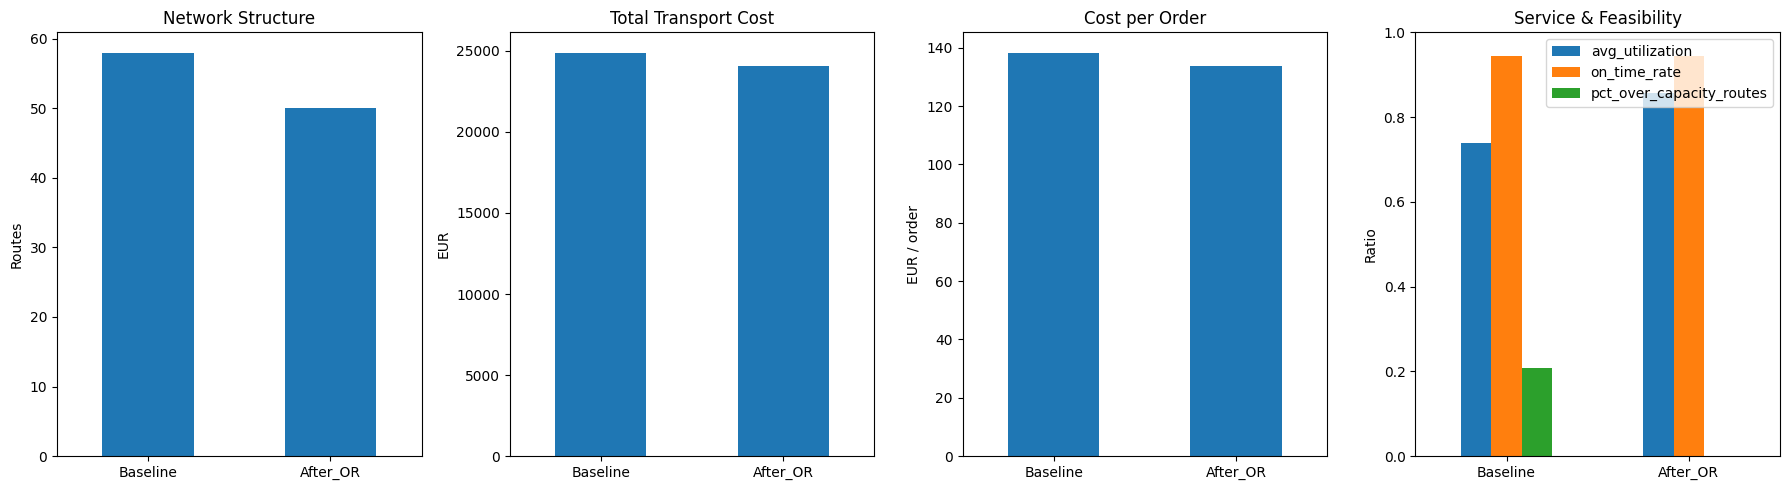

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

comparison = pd.DataFrame({"Baseline": baseline, "After_OR": after_or}).T

fig, axs = plt.subplots(1, 4, figsize=(18,5))

# Panel 1: Structure
comparison[["routes"]].plot(kind="bar", ax=axs[0], legend=False)
axs[0].set_title("Network Structure")
axs[0].set_ylabel("Routes")
axs[0].set_xticklabels(comparison.index, rotation=0)

# Panel 2: Total cost
comparison[["total_cost_eur"]].plot(kind="bar", ax=axs[1], legend=False)
axs[1].set_title("Total Transport Cost")
axs[1].set_ylabel("EUR")
axs[1].set_xticklabels(comparison.index, rotation=0)

# Panel 3: Cost per order
comparison[["cost_per_order_eur"]].plot(kind="bar", ax=axs[2], legend=False)
axs[2].set_title("Cost per Order")
axs[2].set_ylabel("EUR / order")
axs[2].set_xticklabels(comparison.index, rotation=0)

# Panel 4: Service & feasibility
comparison[["avg_utilization","on_time_rate","pct_over_capacity_routes"]].plot(kind="bar", ax=axs[3])
axs[3].set_title("Service & Feasibility")
axs[3].set_ylabel("Ratio")
axs[3].set_ylim(0, 1)
axs[3].set_xticklabels(comparison.index, rotation=0)

plt.tight_layout()
plt.show()
